In [1]:
import pandas as pd
import backtrader as bt
import os
import sys
import datetime

df = pd.read_csv(r"C:\Users\lixin\Desktop\data\data.csv")
df["date"] = df["date"].map(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))


In [18]:
class MyStrategy(bt.Strategy):

    def log(self, txt,dt=None,doprint=False):
#         doprint=self.print_log
        ''' trading record '''

        if doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # initialize relavant data
        self.dataclose = self.datas[0].close
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.log_writeout = []
        # Trading stragtegy
        # MA5
        self.sma5 = bt.indicators.WeightedMovingAverage(self.datas[0], period=5, plotname='mysma')
        #  MA10
        self.sma10 = bt.indicators.WeightedMovingAverage( self.datas[0], period=10)

            
    def notify_order(self, order):
        """
        Arguments:
        order {object} -- order status
        """
        if order.status in [order.Submitted, order.Accepted]:
            # if order already processed. do nothing
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    "BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f"
                    % (order.executed.price, order.executed.value, order.executed.comm)
                )
                self.log_writeout.append( "%s, BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f"
                    % (self.datas[0].datetime.date(0),order.executed.price, order.executed.value, order.executed.comm))
            
                # record price when buying
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                self.bar_executed_close = self.dataclose[0]
                
            else:
                self.log("SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f"
                    % (order.executed.price, order.executed.value, order.executed.comm), doprint=False)
                self.log_writeout.append("%s,SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f"
                    % (self.datas[0].datetime.date(0),order.executed.price, order.executed.value, order.executed.comm))
            self.bar_executed = len(self)
            self.log ('Portfolio Value, %.2f' % cerebro.broker.getvalue(), doprint=False)
            self.log_writeout.append('Portfolio Value, %.2f' % cerebro.broker.getvalue())


        # order rejected for some reason (not enough money for example)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected', doprint=False)

        # order processing complete
        self.order = None

    def notify_trade(self, trade):
        """
        Arguments: trade status
        """
        if not trade.isclosed:
            return
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm), doprint=False)
        
    def next(self):
        """
        strtege logic: MA5>MA10 Buy; MA5<MA10 Sell
        """
        if self.order:
            return

        if not self.position:
            
            if self.sma5[0] > self.sma10[0]:
                self.order = self.buy()
        else:
            if self.sma5[0] < self.sma10[0]:
                self.order = self.sell()

    def stop(self):
        self.log(u'Ending Value %.2f' %
                 (self.broker.getvalue()), doprint=False)
        with open('custom_log.csv', 'a') as e:
            for line in self.log_writeout:
                e.write(line + '\n')
        self.log_writeout = [] 


ticker_lst = []
date_lst=[]
# test the same strategy for every stock of different ticker
for d in list(df.groupby(["ticker"])):
    cerebro = bt.Cerebro()
    strats = cerebro.addstrategy(MyStrategy)
    # buy 100 shares each time
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)
    init_value = 1000000
    cerebro.broker.setcash(init_value)
    cerebro.broker.setcommission(0.005)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='dd')
    cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual_return')

    df_SingleStock=df[df["ticker"]==d[0]]
    # feed data in backtrader
    data = bt.feeds.PandasData(dataname=df_SingleStock,   
        datetime=1,  
        open=2,
        close=2,
        volume=3)
    cerebro.adddata(data)

    with open('custom_log.csv', 'a') as e:
            e.write(d[0] + '\n')
    # execute strategy
    thestrat = cerebro.run()
    print(f"Trade log of {d[0]} has been saved to the csv file.")
    print('Initial Cash amount: %.2f, commition rate  %f' % (init_value,0.005))
    end_value = cerebro.broker.getvalue()
    print("Final Portfolio Value: %.2f" % end_value)
    pnl = end_value - init_value
    print(f"Net Profit for whole period:{pnl:.2f}")
    print(f"Accumulated Return for whole period:{pnl/init_value * 100:.2f}%")
    for y,r in  thestrat[0].analyzers.annual_return.get_analysis().items():
        print(y,f"Annulized Return: {r:.4f}%")
    if (thestrat[0].analyzers.mysharpe.get_analysis()['sharperatio']) is not None:
        print('Sharpe Ratio:', f"{thestrat[0].analyzers.mysharpe.get_analysis()['sharperatio']:.3f}")
    print('Maximum Drawdown:',f"{(thestrat[0].analyzers.dd.get_analysis()['max']['drawdown']):.3f}%")

    print('-'*60)
    

Trade log of 1332 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 997739.80
Net Profit for whole period:-2260.20
Accumulated Return for whole period:-0.23%
2013 Annulized Return: 0.0001%
2014 Annulized Return: 0.0008%
2015 Annulized Return: 0.0024%
2016 Annulized Return: -0.0026%
2017 Annulized Return: -0.0007%
2018 Annulized Return: 0.0009%
2019 Annulized Return: -0.0022%
2020 Annulized Return: -0.0019%
2021 Annulized Return: 0.0010%
Sharpe Ratio: -6.362
Maximum Drawdown: 0.671%
------------------------------------------------------------
Trade log of 1333 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 968367.68
Net Profit for whole period:-31632.32
Accumulated Return for whole period:-3.16%
2014 Annulized Return: 0.0005%
2015 Annulized Return: 0.0007%
2016 Annulized Return: -0.0046%
2017 Annulized Return: -0.0069%
2018 Annulized Return: -0.0054%
201

Trade log of 2269 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 960448.88
Net Profit for whole period:-39551.12
Accumulated Return for whole period:-3.96%
2013 Annulized Return: 0.0053%
2014 Annulized Return: 0.0104%
2015 Annulized Return: 0.0279%
2016 Annulized Return: -0.0298%
2017 Annulized Return: -0.0131%
2018 Annulized Return: -0.0020%
2019 Annulized Return: -0.0238%
2020 Annulized Return: -0.0100%
2021 Annulized Return: -0.0038%
Sharpe Ratio: -0.862
Maximum Drawdown: 8.954%
------------------------------------------------------------
Trade log of 2282 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 973077.72
Net Profit for whole period:-26922.28
Accumulated Return for whole period:-2.69%
2013 Annulized Return: 0.0081%
2014 Annulized Return: 0.0025%
2015 Annulized Return: -0.0079%
2016 Annulized Return: 0.0014%
2017 Annulized Return: -0.0062%
2

Trade log of 3099 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 985586.68
Net Profit for whole period:-14413.32
Accumulated Return for whole period:-1.44%
2013 Annulized Return: 0.0015%
2014 Annulized Return: -0.0023%
2015 Annulized Return: 0.0008%
2016 Annulized Return: -0.0040%
2017 Annulized Return: -0.0029%
2018 Annulized Return: -0.0038%
2019 Annulized Return: -0.0021%
2020 Annulized Return: -0.0031%
2021 Annulized Return: 0.0013%
Sharpe Ratio: -5.598
Maximum Drawdown: 2.122%
------------------------------------------------------------
Trade log of 3101 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 966366.77
Net Profit for whole period:-33633.23
Accumulated Return for whole period:-3.36%
2013 Annulized Return: -0.0025%
2014 Annulized Return: -0.0080%
2015 Annulized Return: -0.0049%
2016 Annulized Return: -0.0011%
2017 Annulized Return: -0.0025

Trade log of 3863 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 978299.63
Net Profit for whole period:-21700.37
Accumulated Return for whole period:-2.17%
2013 Annulized Return: -0.0005%
2014 Annulized Return: -0.0013%
2015 Annulized Return: -0.0007%
2016 Annulized Return: -0.0027%
2017 Annulized Return: -0.0037%
2018 Annulized Return: -0.0067%
2019 Annulized Return: 0.0016%
2020 Annulized Return: -0.0084%
2021 Annulized Return: 0.0005%
Sharpe Ratio: -3.951
Maximum Drawdown: 2.433%
------------------------------------------------------------
Trade log of 3864 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 998234.81
Net Profit for whole period:-1765.19
Accumulated Return for whole period:-0.18%
2013 Annulized Return: -0.0018%
Maximum Drawdown: 0.289%
------------------------------------------------------------
Trade log of 3865 JT has been saved to t

Trade log of 4208 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 979420.66
Net Profit for whole period:-20579.34
Accumulated Return for whole period:-2.06%
2013 Annulized Return: -0.0041%
2014 Annulized Return: -0.0024%
2015 Annulized Return: -0.0018%
2016 Annulized Return: -0.0015%
2017 Annulized Return: -0.0027%
2018 Annulized Return: -0.0085%
2019 Annulized Return: 0.0008%
2020 Annulized Return: -0.0047%
2021 Annulized Return: 0.0041%
Sharpe Ratio: -3.718
Maximum Drawdown: 2.633%
------------------------------------------------------------
Trade log of 4272 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 986436.08
Net Profit for whole period:-13563.92
Accumulated Return for whole period:-1.36%
2013 Annulized Return: 0.0011%
2014 Annulized Return: -0.0017%
2015 Annulized Return: -0.0031%
2016 Annulized Return: 0.0019%
2017 Annulized Return: -0.0036%

Trade log of 4689 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 999728.29
Net Profit for whole period:-271.71
Accumulated Return for whole period:-0.03%
2013 Annulized Return: 0.0011%
2014 Annulized Return: -0.0008%
2015 Annulized Return: -0.0013%
2016 Annulized Return: -0.0016%
2017 Annulized Return: -0.0010%
2018 Annulized Return: -0.0008%
2019 Annulized Return: 0.0016%
2020 Annulized Return: 0.0028%
2021 Annulized Return: -0.0002%
Sharpe Ratio: -7.111
Maximum Drawdown: 0.641%
------------------------------------------------------------
Trade log of 4704 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 959055.99
Net Profit for whole period:-40944.01
Accumulated Return for whole period:-4.09%
2013 Annulized Return: 0.0018%
2014 Annulized Return: -0.0033%
2015 Annulized Return: 0.0059%
2016 Annulized Return: -0.0081%
2017 Annulized Return: 0.0046%
201

Trade log of 5232 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 949632.85
Net Profit for whole period:-50367.15
Accumulated Return for whole period:-5.04%
2013 Annulized Return: 0.0035%
2014 Annulized Return: -0.0065%
2015 Annulized Return: -0.0034%
2016 Annulized Return: -0.0042%
2017 Annulized Return: -0.0038%
2018 Annulized Return: -0.0074%
2019 Annulized Return: -0.0155%
2020 Annulized Return: -0.0167%
2021 Annulized Return: 0.0027%
Sharpe Ratio: -2.393
Maximum Drawdown: 6.242%
------------------------------------------------------------
Trade log of 5233 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 981877.03
Net Profit for whole period:-18122.97
Accumulated Return for whole period:-1.81%
2013 Annulized Return: 0.0096%
2014 Annulized Return: -0.0052%
2015 Annulized Return: -0.0046%
2016 Annulized Return: 0.0017%
2017 Annulized Return: -0.0008%

Trade log of 5711 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 993355.13
Net Profit for whole period:-6644.87
Accumulated Return for whole period:-0.66%
2013 Annulized Return: -0.0016%
2014 Annulized Return: -0.0033%
2015 Annulized Return: -0.0049%
2016 Annulized Return: 0.0062%
2017 Annulized Return: 0.0045%
2018 Annulized Return: -0.0085%
2019 Annulized Return: 0.0044%
2020 Annulized Return: -0.0015%
2021 Annulized Return: -0.0019%
Sharpe Ratio: -2.348
Maximum Drawdown: 1.666%
------------------------------------------------------------
Trade log of 5713 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 1001521.74
Net Profit for whole period:1521.74
Accumulated Return for whole period:0.15%
2013 Annulized Return: -0.0040%
2014 Annulized Return: 0.0068%
2015 Annulized Return: -0.0093%
2016 Annulized Return: -0.0001%
2017 Annulized Return: 0.0203%
201

Trade log of 6305 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 990609.58
Net Profit for whole period:-9390.42
Accumulated Return for whole period:-0.94%
2013 Annulized Return: 0.0008%
2014 Annulized Return: 0.0004%
2015 Annulized Return: -0.0100%
2016 Annulized Return: -0.0062%
2017 Annulized Return: 0.0125%
2018 Annulized Return: -0.0145%
2019 Annulized Return: 0.0001%
2020 Annulized Return: 0.0027%
2021 Annulized Return: 0.0051%
Sharpe Ratio: -1.436
Maximum Drawdown: 2.806%
------------------------------------------------------------
Trade log of 6326 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 988587.02
Net Profit for whole period:-11412.98
Accumulated Return for whole period:-1.14%
2013 Annulized Return: 0.0005%
2014 Annulized Return: 0.0004%
2015 Annulized Return: -0.0029%
2016 Annulized Return: -0.0063%
2017 Annulized Return: 0.0003%
2018 

Trade log of 6508 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 992358.91
Net Profit for whole period:-7641.09
Accumulated Return for whole period:-0.76%
2013 Annulized Return: 0.0022%
2014 Annulized Return: 0.0001%
2015 Annulized Return: 0.0003%
2016 Annulized Return: -0.0081%
2017 Annulized Return: -0.0022%
Sharpe Ratio: -3.240
Maximum Drawdown: 1.490%
------------------------------------------------------------
Trade log of 6645 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 994002.98
Net Profit for whole period:-5997.02
Accumulated Return for whole period:-0.60%
2019 Annulized Return: -0.0000%
2020 Annulized Return: -0.0065%
2021 Annulized Return: 0.0005%
Sharpe Ratio: -3.745
Maximum Drawdown: 2.214%
------------------------------------------------------------
Trade log of 6674 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, 

Trade log of 6857 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 1019786.35
Net Profit for whole period:19786.35
Accumulated Return for whole period:1.98%
2013 Annulized Return: 0.0007%
2014 Annulized Return: 0.0004%
2015 Annulized Return: -0.0048%
2016 Annulized Return: 0.0049%
2017 Annulized Return: 0.0015%
2018 Annulized Return: -0.0129%
2019 Annulized Return: 0.0237%
2020 Annulized Return: -0.0028%
2021 Annulized Return: 0.0094%
Sharpe Ratio: -0.810
Maximum Drawdown: 2.639%
------------------------------------------------------------
Trade log of 6902 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 973220.71
Net Profit for whole period:-26779.29
Accumulated Return for whole period:-2.68%
2013 Annulized Return: 0.0042%
2014 Annulized Return: -0.0038%
2015 Annulized Return: -0.0110%
2016 Annulized Return: -0.0131%
2017 Annulized Return: 0.0077%
2018

Trade log of 7202 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 993537.51
Net Profit for whole period:-6462.49
Accumulated Return for whole period:-0.65%
2013 Annulized Return: 0.0028%
2014 Annulized Return: -0.0010%
2015 Annulized Return: -0.0003%
2016 Annulized Return: -0.0041%
2017 Annulized Return: 0.0005%
2018 Annulized Return: 0.0000%
2019 Annulized Return: -0.0007%
2020 Annulized Return: -0.0034%
2021 Annulized Return: -0.0003%
Sharpe Ratio: -5.609
Maximum Drawdown: 1.241%
------------------------------------------------------------
Trade log of 7203 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 947284.18
Net Profit for whole period:-52715.82
Accumulated Return for whole period:-5.27%
2013 Annulized Return: -0.0039%
2014 Annulized Return: -0.0044%
2015 Annulized Return: -0.0176%
2016 Annulized Return: -0.0126%
2017 Annulized Return: 0.0028%


Trade log of 7762 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 991822.57
Net Profit for whole period:-8177.43
Accumulated Return for whole period:-0.82%
2013 Annulized Return: 0.0008%
2014 Annulized Return: 0.0001%
2015 Annulized Return: -0.0039%
2016 Annulized Return: -0.0016%
2017 Annulized Return: -0.0007%
2018 Annulized Return: -0.0028%
2019 Annulized Return: 0.0011%
2020 Annulized Return: -0.0018%
2021 Annulized Return: 0.0006%
Sharpe Ratio: -6.604
Maximum Drawdown: 1.059%
------------------------------------------------------------
Trade log of 7832 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 985428.17
Net Profit for whole period:-14571.83
Accumulated Return for whole period:-1.46%
2019 Annulized Return: 0.0016%
2020 Annulized Return: -0.0062%
2021 Annulized Return: -0.0100%
Sharpe Ratio: -3.081
Maximum Drawdown: 2.499%
-------------------

Trade log of 8252 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 985337.03
Net Profit for whole period:-14662.97
Accumulated Return for whole period:-1.47%
2013 Annulized Return: 0.0006%
2014 Annulized Return: -0.0011%
2015 Annulized Return: 0.0007%
2016 Annulized Return: -0.0060%
2017 Annulized Return: -0.0004%
2018 Annulized Return: -0.0080%
2019 Annulized Return: -0.0011%
2020 Annulized Return: -0.0012%
2021 Annulized Return: 0.0019%
Sharpe Ratio: -3.776
Maximum Drawdown: 2.149%
------------------------------------------------------------
Trade log of 8253 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 983027.59
Net Profit for whole period:-16972.41
Accumulated Return for whole period:-1.70%
2013 Annulized Return: -0.0027%
2014 Annulized Return: -0.0071%
2015 Annulized Return: -0.0051%
2016 Annulized Return: -0.0010%
2017 Annulized Return: -0.0003

Trade log of 8411 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 984799.25
Net Profit for whole period:-15200.75
Accumulated Return for whole period:-1.52%
2013 Annulized Return: 0.0006%
2014 Annulized Return: -0.0038%
2015 Annulized Return: -0.0030%
2016 Annulized Return: -0.0023%
2017 Annulized Return: -0.0026%
2018 Annulized Return: -0.0030%
2019 Annulized Return: -0.0014%
2020 Annulized Return: -0.0029%
2021 Annulized Return: 0.0031%
Sharpe Ratio: -5.639
Maximum Drawdown: 2.171%
------------------------------------------------------------
Trade log of 8601 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 991000.67
Net Profit for whole period:-8999.33
Accumulated Return for whole period:-0.90%
2013 Annulized Return: 0.0017%
2014 Annulized Return: -0.0016%
2015 Annulized Return: -0.0023%
2016 Annulized Return: -0.0014%
2017 Annulized Return: -0.0009%

Trade log of 8815 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 1001143.66
Net Profit for whole period:1143.66
Accumulated Return for whole period:0.11%
2013 Annulized Return: 0.0011%
Maximum Drawdown: 0.406%
------------------------------------------------------------
Trade log of 8830 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 967658.27
Net Profit for whole period:-32341.73
Accumulated Return for whole period:-3.23%
2013 Annulized Return: 0.0089%
2014 Annulized Return: -0.0110%
2015 Annulized Return: -0.0068%
2016 Annulized Return: -0.0113%
2017 Annulized Return: -0.0042%
2018 Annulized Return: -0.0041%
2019 Annulized Return: -0.0124%
2020 Annulized Return: 0.0018%
2021 Annulized Return: 0.0065%
Sharpe Ratio: -1.843
Maximum Drawdown: 5.875%
------------------------------------------------------------
Trade log of 9001 JT has been saved to the 

Trade log of 9107 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 980639.78
Net Profit for whole period:-19360.22
Accumulated Return for whole period:-1.94%
2013 Annulized Return: -0.0008%
2014 Annulized Return: 0.0022%
2015 Annulized Return: -0.0135%
2016 Annulized Return: -0.0034%
2017 Annulized Return: -0.0053%
2018 Annulized Return: -0.0040%
2019 Annulized Return: 0.0073%
2020 Annulized Return: -0.0026%
2021 Annulized Return: 0.0007%
Sharpe Ratio: -2.258
Maximum Drawdown: 2.736%
------------------------------------------------------------
Trade log of 9202 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 983590.89
Net Profit for whole period:-16409.11
Accumulated Return for whole period:-1.64%
2013 Annulized Return: 0.0024%
2014 Annulized Return: 0.0047%
2015 Annulized Return: 0.0006%
2016 Annulized Return: -0.0078%
2017 Annulized Return: 0.0019%
20

Trade log of 9613 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 995012.08
Net Profit for whole period:-4987.92
Accumulated Return for whole period:-0.50%
2013 Annulized Return: 0.0014%
2014 Annulized Return: -0.0002%
2015 Annulized Return: -0.0013%
2016 Annulized Return: -0.0019%
2017 Annulized Return: -0.0002%
2018 Annulized Return: -0.0018%
2019 Annulized Return: -0.0015%
2020 Annulized Return: -0.0018%
2021 Annulized Return: 0.0023%
Sharpe Ratio: -7.281
Maximum Drawdown: 0.973%
------------------------------------------------------------
Trade log of 9681 JT has been saved to the csv file.
Initial Cash amount: 1000000.00, commition rate  0.005000
Final Portfolio Value: 989745.56
Net Profit for whole period:-10254.44
Accumulated Return for whole period:-1.03%
2013 Annulized Return: 0.0027%
2014 Annulized Return: -0.0035%
2015 Annulized Return: -0.0018%
2016 Annulized Return: -0.0026%
2017 Annulized Return: -0.0012%

<IPython.core.display.Javascript object>


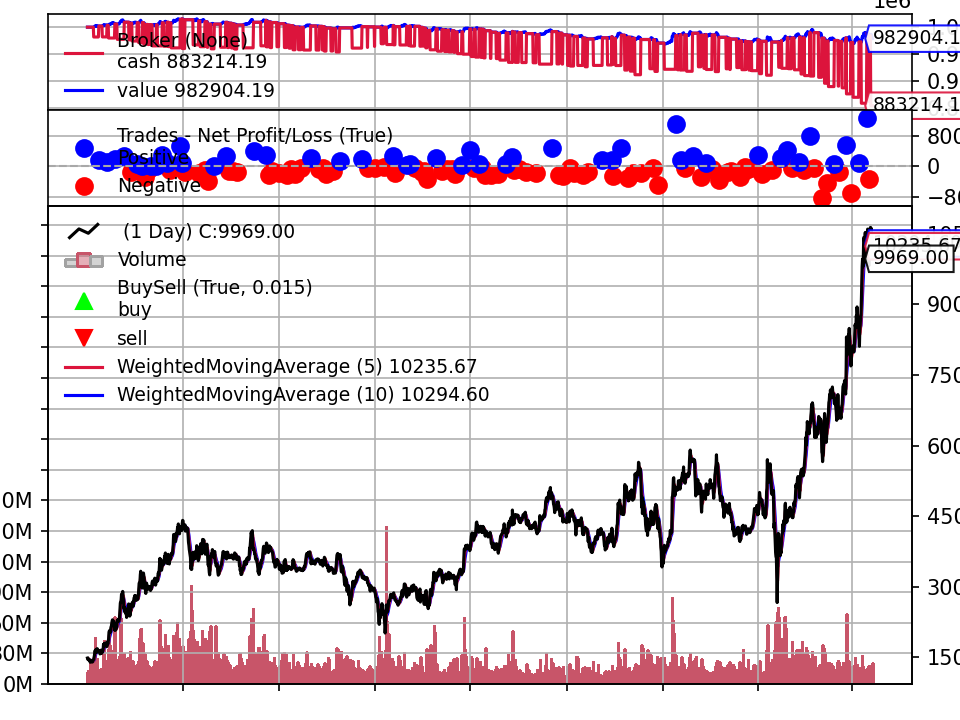

[[<Figure size 640x480 with 4 Axes>]]

In [20]:
# plot of 9984 JT  as an example
cerebro.plot()